# <center>АНАЛИЗ ЭФФЕКТИВНОСТИ ДВУХ ВАРИАНТОВ ПОСАДОЧНОЙ СТРАНИЦЫ
# <center>(Анализ результатов A/B-тестирования)

Туристическая фирма планирует запустить новую акцию, чтобы продать как можно больше туров. Команда web-дизайнеров разработала два варианта посадочной страницы официального сайта и провела A/B-тестирование. В результате эксперимента были собраны данные — скачайте их по [ссылке](https://lms-cdn.skillfactory.ru/assets/courseware/v1/3274d20d12cca49b6ce3d18d75ba8826/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/ab_data_tourist.zip), если необходимо загрузить на локальный компьютер.

Турфирма предлагает следующие туры, цена отражена в столбце *price* в датасете:
* Таиланд — 100 000 рублей;
* Турция — 60 000 рублей;
* Мальдивы — 200 000 рублей;
* Санкт-Петербург — 10 000 рублей;
* Камчатка — 150 000 рублей.

**Наша задача:** анализ результатов тестирования и составление рекомендаций-выводов для заказчика. 

**Критериями оценки тестирования** выбирем: конверсия покупки и ежедневный средний чек.

Импортируем необходимые библиотеки.

In [392]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.stats.proportion import proportions_ztest  # Z-критерий для пропорций
from scipy.stats import shapiro                             # критерий Шапиро-Уилка для определения нормальности распределения
from scipy.stats import ttest_ind                           # двухвыборочный t-критерий для сравнения среднего
from scipy.stats import norm                                # модуль нормального распределения
from scipy.stats import t                                   # модуль распределения Стьюдента (t-распределения)

import warnings
warnings.filterwarnings("ignore")

### 1. Предобработка данных
**1.1 Загрузим данные и проведем общий обзор**

In [393]:
url = 'https://lms-cdn.skillfactory.ru/assets/courseware/v1/3274d20d12cca49b6ce3d18d75ba8826/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/ab_data_tourist.zip'
data = pd.read_csv(url)
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [394]:
display(data.info(), data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


None

user_id     0
date        0
group       0
purchase    0
price       0
dtype: int64

Мы не наблюдаем пропусков, дата представлена типом 'object', переведем ее в формат datetime.

**Признаки:**
* user_id — идентификатор пользователя сайта;
* data — дата посещения сайта;
* group — группа теста (контрольная — А или тестовая — B);
* purchase — признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет);
* price — цена купленного тура (если покупка не состоялась, цена равна 0).

In [395]:
# преобразуем дату в нужный тип данных
data.date = pd.to_datetime(data['date'])
data.date = data.date.dt.date

**1.2 Удаление дубликатов**

При анализе результатов эксперимента важно убедиться, чтобы в обеих группах находились только уникальные пользователи: что пользователи из группы А видели только вариант страницы А и наоборот, только так мы можем полагаться на корректность результатов и проанализировать их.

In [396]:
dupl_users = data.duplicated(subset='user_id')
print('Количество пользователей, попавших в обе группы: {}'.format(data[dupl_users].shape[0]))

Количество пользователей, попавших в обе группы: 3894


In [397]:
# очистим данные от пользователей, увидивших оба варианта страницы
data_cleaned = data.drop_duplicates(subset='user_id')
data_cleaned.shape[0]

290584

**1.3 Длительность эксперимента, распределение собранных данных по группам**

Мы очистили наши данные  и можем подготовить их к анализу.
Прежде всего, сгруппируем данные по дате и группе, тем самым мы увидим длительность эксперимента в обеих группах, а также вычислим ежедневные показатели в группах: количество посетителей сайта, количество совершённых целевых действий (purchase - покупка тура) и общую ежедневную выручку (price).

Дополнительно для удобства сбросим индекс на сгруппированной таблице c помощью метода reset_index() и переименуем столбец user_id в count_users с помощью метода rename().

In [398]:
daily_data = data_cleaned.groupby(['date', 'group']).agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}).\
                         reset_index().rename(columns={'user_id': 'count_users'})
daily_data.tail(6)

,date,group,count_users,purchase,price
40,2021-01-22,A,6581,785,63470000
41,2021-01-22,B,6660,783,68530000
42,2021-01-23,A,6703,849,71340000
43,2021-01-23,B,6640,807,69090000
44,2021-01-24,A,3761,444,33200000
45,2021-01-24,B,3678,440,38340000


In [399]:
print('Длительность тестирования в контрольной группе А: {} to {} \nДлительность тестирования в тестовой группе В: {} to {}'.
format(daily_data[daily_data['group']=='A']['date'].min(), daily_data[daily_data['group']=='A']['date'].max(),
       daily_data[daily_data['group']=='B']['date'].min(), daily_data[daily_data['group']=='B']['date'].max()))

Длительность тестирования в контрольной группе А: 2021-01-02 to 2021-01-24 
Длительность тестирования в тестовой группе В: 2021-01-02 to 2021-01-24


Время проведения эксперимента составило 23 дня одинаково в обеих группах.

Визуализируем распределение показателей по дням в группах.

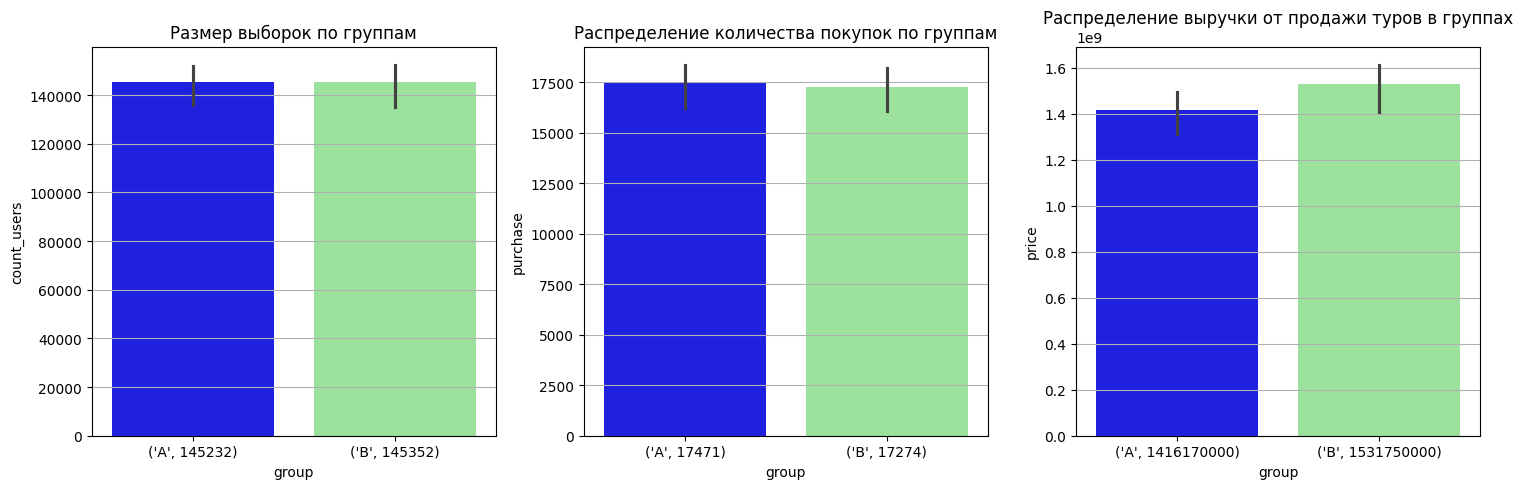

In [400]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
# столбчатая диаграмма для отображения количества посетителей
sns.barplot(daily_data, x='group', y='count_users', hue='group', estimator='sum', palette=['blue', 'lightgreen'], ax=ax[0])
ax[0].set_title('Размер выборок по группам')
ax[0].grid(axis='y')
ax[0].set_xticklabels([('A', daily_data[daily_data['group']=='A']['count_users'].sum()), ('B', daily_data[daily_data['group']=='B']['count_users'].sum())])

# столбчатая диаграмма для отображения общего количества совершенных действий (purchase-покупок)
sns.barplot(daily_data, x='group', y='purchase', hue='group', estimator='sum', palette=['blue', 'lightgreen'], ax=ax[1])
ax[1].set_title('Распределение количества покупок по группам')
ax[1].set_xticklabels([('A', daily_data[daily_data['group']=='A']['purchase'].sum()), ('B', daily_data[daily_data['group']=='B']['purchase'].sum())])
ax[1].grid(axis='y')

# столбчатая диаграмма для отображения общего оборота выручки по группам
sns.barplot(daily_data, x='group', y='price', hue='group', estimator='sum', palette=['blue', 'lightgreen'], ax=ax[2])
ax[2].set_title('Распределение выручки от продажи туров в группах')
ax[2].set_xticklabels([('A', daily_data[daily_data['group']=='A']['price'].sum()), ('B', daily_data[daily_data['group']=='B']['price'].sum())])
plt.grid(axis='y')
plt.tight_layout();


Группы сбалансированы по количеству пользователей.\
Предварительно, мы можем сказать, что разные дизайны страниц не повлияли на частоту совершения действия, то есть покупку тура, практически одинаковое количество, но наблюдаем, что пользователи из тестовой группы В принесли больше выручки, возможно оформление страницы в тестовой группе убеждает выбирать более дорогие туры.

### 2. Анализ конверсии и среднего чека в группах
**2.1** Рассчитаем **ежедневную конверсию** - это отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия в день (purchase - покупка тура), к ежедневному общему числу посетителей сайта (count_users), умноженная на 100 %:
$$ conv_{t} = \frac{N_{t}^{+}}{N_{t}} \times 100\ %$$

,date,group,count_users,purchase,price,conversion
0,2021-01-02,A,2843,355,29180000,12.486810
1,2021-01-02,B,2855,342,29590000,11.978984
2,2021-01-03,A,6595,751,62260000,11.387415
3,2021-01-03,B,6625,751,65320000,11.335849
4,2021-01-04,A,6565,800,64120000,12.185834


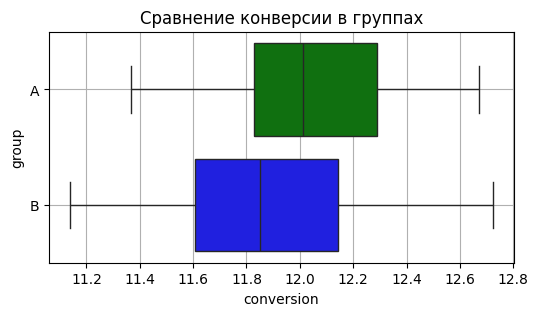

In [401]:
# вычисляем конверсию
daily_data['conversion'] = (daily_data.purchase / daily_data.count_users)*100
display(daily_data.head())

# визуализируем
fig = plt.figure(figsize=(6, 3)) 
# строим коробчатую диаграмму для конверсии (conversion) по признаку группы (group)
sns.boxplot(data=daily_data, x='conversion', y='group', palette=['green', 'blue']) 
plt.title('Сравнение конверсии в группах')   # название графика
plt.grid();                                  # задаём отображение сетки

Визуально:
1. Медианное значение ежедневной конверсии в группе А выше, чем в группе B.
2. Разброс конверсии в группе B больше, чем в группе A.

Проверим также, есть ли численная разница между значениями, вычислим среднее и медиану конверсии в обеих группах.

Отобразим на графике конверсию по дням.

            mean     median
group                      
A      12.036922  12.011340
B      11.886402  11.850845


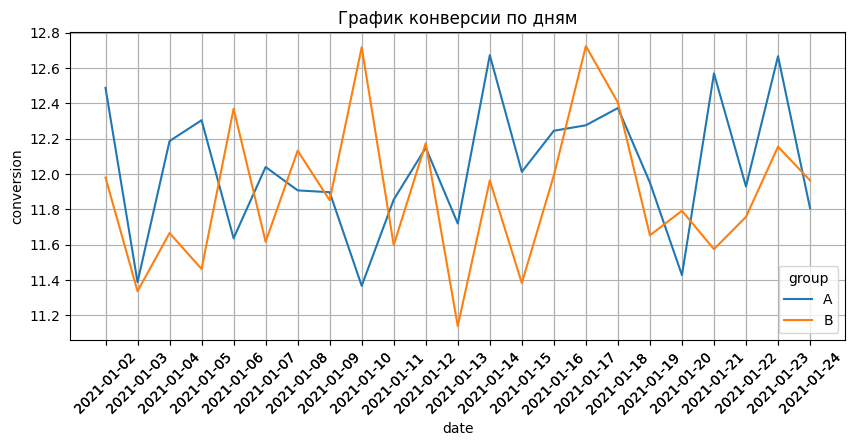

In [402]:
# сравнение среднего и медианы конверсии по группам
mean_conversion = daily_data.groupby('group')['conversion'].agg(['mean', 'median'])
print(mean_conversion)

# визуализация ежедневной конверсии по группам
fig = plt.figure(figsize=(10, 4))
# строим lineplot для конверсии по дням в каждой группе
sns.lineplot(data=daily_data, x='date', y='conversion', hue='group')
plt.title('График конверсии по дням')                         # навзание графику
plt.xticks(rotation=45)                                       # поворот меток на оси абсцисс
plt.xticks(daily_data.date, labels=daily_data.date.tolist())  # подписи на оси абсцисс по всем дня эксперимента
plt.grid();

Итак, мы наблюдаем сильные колебания конверсии у обеих групп ежедневно, естественно, определить по такому графику, какая группа лучше, невозможно. Поэтому мы применим кумулятивную конверсию - конверсию, накопленную по дням. Кумулятивная метрика считается стабилизированной, когда на графике прекращаются резкие колебания показателя, и линия постепенно выравнивается в горизонтальную прямую.\
Для расчёта кумулятивного показателя суммы в Pandas применяют специальный метод cumsum().\
Формула кумулятивной суммы:
$$S_{t}=S_{t-1}+x_{t}$$
$x_t$ -  значение показателя в день t;
$S_t$ - значение суммы в день t.\
Для нахождения кумулятивной конверсии мы вычислим отношение кумулятивной суммы покупок (purchase) к кумулятивной сумме количества посетителей сайта (count_users), сгруппированные по group.

,date,group,count_users,purchase,price,conversion,cum_users,cum_purchase,cum_conversion
0,2021-01-02,A,2843,355,29180000,12.486810,2843,355,12.486810
1,2021-01-02,B,2855,342,29590000,11.978984,2855,342,11.978984
2,2021-01-03,A,6595,751,62260000,11.387415,9438,1106,11.718584
3,2021-01-03,B,6625,751,65320000,11.335849,9480,1093,11.529536
4,2021-01-04,A,6565,800,64120000,12.185834,16003,1906,11.910267


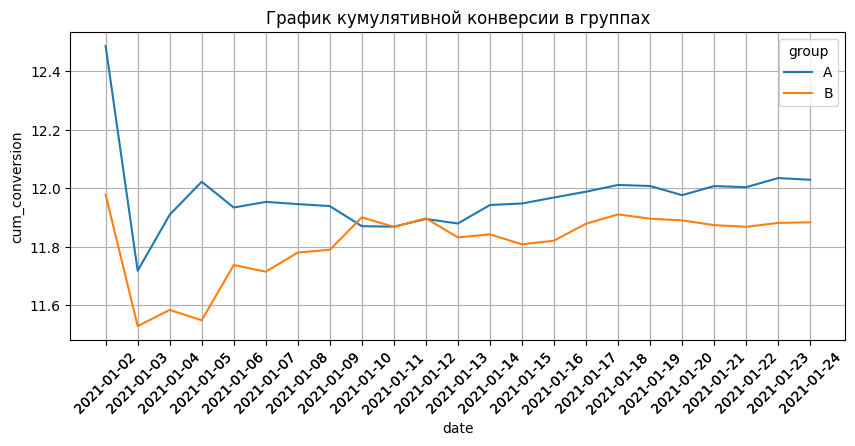

In [403]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users'] = daily_data.groupby(['group'])['count_users'].cumsum()
# вычисляем кумулятивную сумму количества покупок
daily_data['cum_purchase'] = daily_data.groupby(['group'])['purchase'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_purchase']/daily_data['cum_users'] * 100
display(daily_data.head())

# визуализация кумулятивной конверсии по группам
fig = plt.figure(figsize=(10, 4))
# строим линейный график для кумулятивной конверсии в каждой группе
sns.lineplot(data=daily_data, x='date', y='cum_conversion', hue='group')
plt.title('График кумулятивной конверсии в группах')              # навзание графика
plt.xticks(rotation=45)                                           # поворот меток на оси абсцисс
plt.xticks(daily_data.date, labels=daily_data.date.tolist())
plt.grid();

Мы видим, что примерно с 13 числа скачки прекращаются и графики стабилизируются (напоминают прямые), следовательно, длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах.

**2.2 Средний чек**

Посмотри на ежедневный средний чек в группах и сравним.

Прежде всего, давайте вернемся к изначальной таблице,  как мы помним, общая выручка в тестовой группе В оказалась выше, какие же туры предпочитают в группах.

group  price           
A      nothing             127761
       Turkey                5267
       Saint-Petersburg      5175
       Kamchatka             3476
       Thailand              1836
       Maldives              1717
B      nothing             128078
       Thailand              5234
       Saint-Petersburg      5188
       Kamchatka             3429
       Turkey                1732
       Maldives              1691
Name: price, dtype: int64

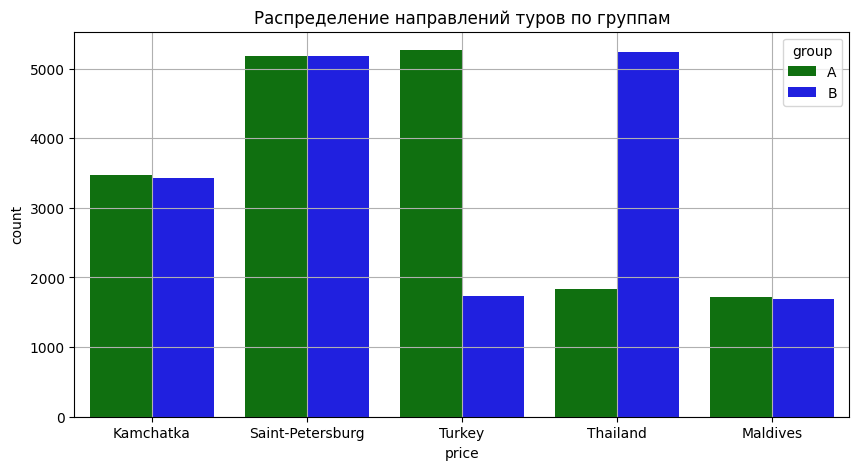

In [404]:
# сформируем таблицу с турами, то есть стоимость в price заменим на страну, куда попался тур
tour_data = data.drop_duplicates(subset='user_id').\
    replace({60000: 'Turkey', 10000: 'Saint-Petersburg', 150000: 'Kamchatka', 100000: 'Thailand', 200000: 'Maldives', 0: 'nothing'})
# посдситаем количество купленных туров в каждой группе
display(tour_data.groupby('group')['price'].value_counts())

# исключим из данных о турах категорию без покупки (nothing)
tour_data.drop(tour_data[tour_data['price'] == 'nothing'].index, inplace = True)
# визуализируем распределение в группах по турам за исключением категории без покупки тура (nothing)
plt.figure(figsize=(10,5))
# количественная столбчатая диаграмма туров, сгруппированных по группам
sns.countplot(data=tour_data, x='price', hue='group', palette=['green', 'blue'])
plt.title('Распределение направлений туров по группам')
plt.grid();

In [405]:
# посчитаем, какой вклад (в процентах) в выручку вносит каждая группа
total_price = daily_data['price'].sum()
part_A = (daily_data[daily_data['group']=='A']['price'].sum())*100/total_price
part_B = (daily_data[daily_data['group']=='B']['price'].sum())*100/total_price

print('Доли выручки в группах А: {}%, В: {}%'.format(round(part_A), round(part_B)))

Доли выручки в группах А: 48%, В: 52%


Итак, разница в друх группах наблюдается только в двух направлениях туров: Турция (стоимостью 60000 руб.) и Таиланд (стоимостью 100000 руб.), причем разница практически зеркальна (количество туров в Турцию практически равно количеству туров в Таиланд в группе В, а количество туров в Турцию в группе В практически равно количеству туров в Таиланд в группе А), а так как стоимость туров в Таиланд выше, то и общая выручка в группе В оказалась выше, разница составила 4%.\
Таким образом, можем предположить, что web-дизайнеры для разных групп по-разному представляют(рекламируют) два направления: Турция и Таиланд.\
Посетители, которые не приобрели никакой тур, также практически равны по численности.

**Итак, теперь мы рассчитаем ежедневный средний чек в обеих группах:**\
отношение ежедневной выручки (price) к ежедневным покупкам (purchase)

In [406]:
daily_data['check'] = daily_data['price']/daily_data['purchase']
daily_data.head()

,date,group,count_users,purchase,price,conversion,cum_users,cum_purchase,cum_conversion,check
0,2021-01-02,A,2843,355,29180000,12.486810,2843,355,12.486810,82197.183099
1,2021-01-02,B,2855,342,29590000,11.978984,2855,342,11.978984,86520.467836
2,2021-01-03,A,6595,751,62260000,11.387415,9438,1106,11.718584,82902.796272
3,2021-01-03,B,6625,751,65320000,11.335849,9480,1093,11.529536,86977.363515
4,2021-01-04,A,6565,800,64120000,12.185834,16003,1906,11.910267,80150.000000


               mean        median
group                            
A      80954.100568  81796.778191
B      88585.283827  88096.446701


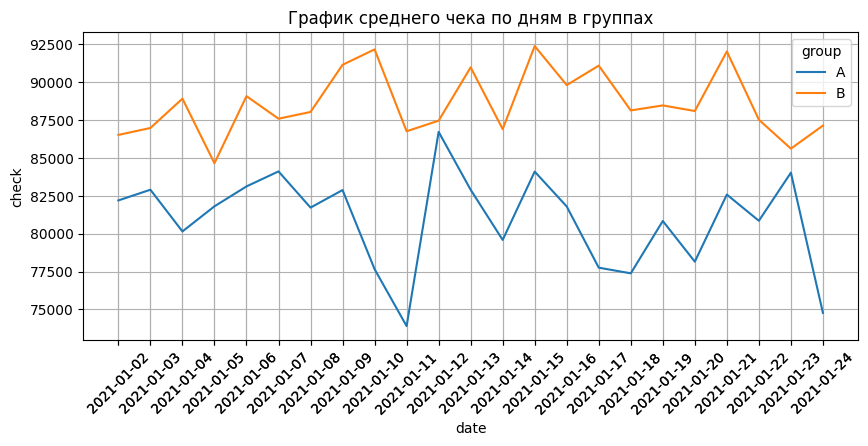

In [407]:
# сравнение среднего чека в группах
mean_check = daily_data.groupby('group')['check'].agg(['mean', 'median'])
print(mean_check)

# визуализация ежедневного среднего чека по группам
fig = plt.figure(figsize=(10, 4))
# строим линейный график распределения среднего чека в каждой группе
sns.lineplot(data=daily_data, x='date', y='check', hue='group')
plt.title('График среднего чека по дням в группах')           # навзание графика
plt.xticks(rotation=45)                                       # поворот меток на оси абсцисс
plt.xticks(daily_data.date, labels=daily_data.date.tolist())
plt.grid();

Итак, мы наблюдаем те же сильные колебания в группах, как и при конверсии.\
Поступим как прежде и посчитаем кумулятивную сумму чеков и посмотрим, стабилизируется ли данная метрика на протяжении эксперимента.

,date,group,count_users,purchase,price,conversion,cum_users,cum_purchase,cum_conversion,check,cum_price,cum_check
0,2021-01-02,A,2843,355,29180000,12.486810,2843,355,12.486810,82197.183099,29180000,82197.183099
1,2021-01-02,B,2855,342,29590000,11.978984,2855,342,11.978984,86520.467836,29590000,86520.467836
2,2021-01-03,A,6595,751,62260000,11.387415,9438,1106,11.718584,82902.796272,91440000,82676.311031
3,2021-01-03,B,6625,751,65320000,11.335849,9480,1093,11.529536,86977.363515,94910000,86834.400732
4,2021-01-04,A,6565,800,64120000,12.185834,16003,1906,11.910267,80150.000000,155560000,81615.949633


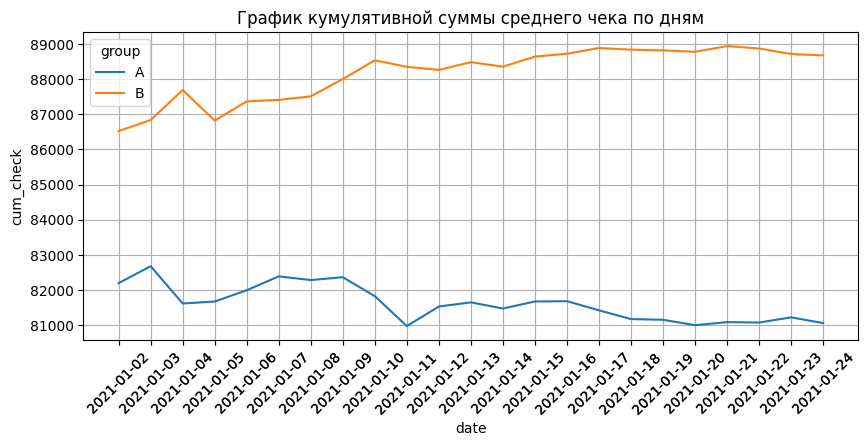

In [408]:
# вычисляем кумулятивную сумму ежедневной выручки (price)
daily_data['cum_price'] = daily_data.groupby(['group'])['price'].cumsum()

# вычисляем кумулятивную сумму среднего чека
daily_data['cum_check'] = daily_data['cum_price']/daily_data['cum_purchase']
display(daily_data.head())

# визуализация кумулятивной суммы среднего чека по дням в группах
fig = plt.figure(figsize=(10, 4))
# строим линейный график для кумулятивной суммы среднего чека в каждой группе
sns.lineplot(data=daily_data, x='date', y='cum_check', hue='group')
plt.title('График кумулятивной суммы среднего чека по дням')         # название графика
plt.xticks(rotation=45)                                              # поворот меток на оси абсцисс
plt.xticks(daily_data.date, labels=daily_data.date.tolist())
plt.grid();

График достаточно быстро стабилизировался (вышел на относительную прямую) примерно с 10 числа и напомним, что конверсия была выше в группе А, а вот по метрике среднего чека мы можем предположить, что вариант страницы для группы В более привлекателен.

Ситуация у нас неоднозначная и сразу сказать, если ли статистически значимая разница между вариантами страниц в группах или оба варианта равнозначны по выбранным метрикам, мы не можем, что в конверсии, что в среднем чеке разница очень небольшая, поэтому мы переходим в точной "артиллерии" - статистическим тестам.

### 3. Статистический анализ

**3.1 Статистический тест для пропорций Z-тест для определения статистической значимости изменения конверсии.**

Группируем данные по признаку группы для расчета количества положительных действий - конверсии (посетитель приобрел тур) и общего количество посетителей каждого из вариантов (то есть посетители страницы для группы А и посетители, увидевшие страницу В).

In [409]:
converted_df = data.drop_duplicates(subset='user_id').groupby('group')['purchase'].agg(['sum', 'count'])
display(converted_df)

,sum,count
group,,
A,17471,145232
B,17274,145352


Мы знаем, что группы независимые: пользователи в группах А и B не пересекаются. 

**Z-тест для пропорций**\
Нулевая гипотеза: пропорции (конверсии) в группах A и B равны:  $H_0:p_a=p_b$ 

Альтернативная гипотеза: нет равенства пропорций (конверсии) в группах A и B:  $H_1:p_a \neq p_b$

Z-тест для пропорций реализован в функции proportions_ztest() модуля proportion библиотеки statsmodels.

In [410]:
alpha = 0.05               # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_df['sum'],  # посетители, совершившие конверсию
    nobs=converted_df['count'], # общее число посетителей
    alternative='two-sided',    # двусторонняя альтернативная гипотеза
)
# выводим результат
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.227
У нас нет оснований отвергнуть нулевую гипотезу


Истинные значения конверсий в группах равны (с уровнем значимости 0.05):\
Z-тест для пропорций показал нам, что разницы между вариантами страниц не обнаружено по метрике конверсии.\

Мы помним, что конверсия в группе А была чуть больше, поэтому можем переформулировать гипотезы в пользу конверсии группы А: 
* Нулевая: конверсия в группе А меньше либо равна конверсии в группе B $H_0:p_a \leq p_b$
* Альтернативная: конверсия в группе А больше, чем конверсия в группе B. $H_1: p_a > p_b$

In [411]:
_, p_value = proportions_ztest(count=converted_df['sum'], nobs=converted_df['count'], alternative='larger') # правосторонняя
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.113
У нас нет оснований отвергнуть нулевую гипотезу


Однозначно, по метрике конверсии статистически значимой разницы в успехе между разными вариантами страниц нет.

**3.2 Статистический параметрический T-тест (двухвыборочный t-критерий для нормально распреденных данных) для числовой метрики - среднего чека.**

Чтобы выбрать подходящий статистический тест нам необходимо определить, распределен ли наш признак по нормальному или нет.\
Для этого мы воспользуемся помощью критерия Шапиро-Уилка: функция shapiro() из модуля scipy.stats:
* нулевая гипотеза — распределение нормальное, 
* альтернативная — распределение отлично от нормального:

p-value группы А 0.24
p-value группы B 0.22
Принимаем нулевую гипотезу. Распределение в группе А является нормальным
Принимаем нулевую гипотезу. Распределение в группе B является нормальным


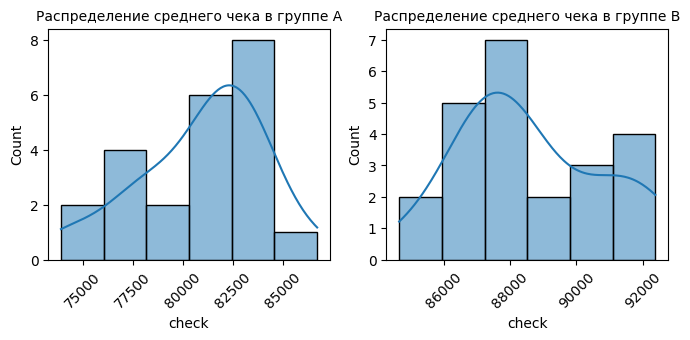

In [412]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
# отобразим распределение среднего чека в группе А на гистограмме
sns.histplot(daily_data[daily_data['group']=='A'], x='check', kde=True, ax=ax[0])
ax[0].set_title('Распределение среднего чека в группе А', fontsize=10)
ax[0].xaxis.set_tick_params(rotation=45)
# отобразим распределение среднего чека в группе В на гистограмме
sns.histplot(daily_data[daily_data['group']=='B'], x='check', kde=True, ax=ax[1])
ax[1].set_title('Распределение среднего чека в группе В', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout;

alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_a = shapiro(daily_data[daily_data['group']=='A']['check'])
shapiro_b = shapiro(daily_data[daily_data['group']=='B']['check'])
print('p-value группы А', round(shapiro_a.pvalue, 2))
print('p-value группы B', round(shapiro_b.pvalue, 2))

# сравниваем полученное p-value для группы А с уровнем значимости
if shapiro_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")


Хотя визуально было сложно определить нормальность распределения, тест нам помог, мы имеем дело с нормально распределенными данными и  можем воспользоваться Т-тестом (функция ttest_ind) для сравнения среднего чека в группах. Предварительно мы наблюдали преимущество в группе В, поэтому проверим одностороннюю гипотезу:
* Нулевая гипотеза: средний чек в группе А больше либо равен среднему чеку в группе В:  $H_0:\mu_a \geq \mu_b$
* Альтернативная гипотеза: средний чек в группе В больше среднего чека в группе А :  $H_1:\mu_a < \mu_b$

In [413]:
alpha = 0.05                  # уровень значимости
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=daily_data[daily_data['group']=='A']['check'],
    b=daily_data[daily_data['group']=='B']['check'],
    alternative='less'        # левосторонняя альтернативная гипотеза
)
print('p-value:', round(results.pvalue, 3))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Мы статистически подтвердили наше предположение, что вариант страницы для группы В более привлекателен, а именно, он принесет больше выручки для турфирмы. 
Итак, по метрике среднего чека разница между вариантами дизайна страниц есть.

Нам осталось построить удобочитаемую информацию для нашего заказчика, а именно мы подкрепим наши выводы доверительными интервалами.

### 4. Доверительные интервалы

**4.1 Доверительный интервал конверсии**

Формула доверительного интервала для истинной пропорции (истинной конверсии):
$$p=\mu=X_{p} \pm z_{крит} \times \sqrt{\frac{X_{p}(1-X_{p})}{n}}$$
* $p$ - конверсия, истинное среднее (математическое ожидание) случайной величины, распределённой по закону Бернулли (два варианта исхода события: покупка тура или непокупка), равно $\mu=p$,
* $X_{p}$ - выборочная пропорция, доля посетителей, совершивших конверсию (покупку тура)
* Компонент $z_{крит}$ в доверительном интервале определяется уровнем надёжности. Уровень надежности $\gamma = 1 -\alpha$, где $\alpha$ — уровень значимости или вероятность ошибки I рода: $$z_{крит}=z_{\frac{1-\gamma}{2}} = z_{\frac{\alpha}{2'}}$$
* $n$ - размер выборки (общее число посетителей в группе)

In [414]:
# отфильтруем данные для группы А
group_A = daily_data[daily_data['group'] == 'A']
# отфильтруем данные для группы B
group_B = daily_data[daily_data['group'] == 'B']

Создаем функцию proportion_conf_interval(), которая будет принимать следующие аргумента: 
* x_p — выборочная пропорция (конверсия), 
* n — размер выборки
* gamma — уровень надёжности (по умолчанию он равен 0.95).\
Функция будет возвращать кортеж из вычисленных границ доверительного интервала.

Значение z-критического для любого уровня значимости можно вычислить при помощи функции norm.ppf() из модуля scipy.stats, важно - она возвращает отрицательный модуль, поэтому добавляем знак минус.

In [415]:
# создаем функцию доверительного интервала для пропорций
def proportion_conf_interval(x_p, n, gamma=0.95):  
    alpha = 1 - gamma                              # уровень значимости
    z_crit = -norm.ppf(alpha/2)                    # z-критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5    # погрешность
    lower_bound = x_p - eps                        # левая (нижняя) граница
    upper_bound = x_p + eps                        # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

# применим функцию для конверсии в группе А
lower_bound_a, upper_bound_a  = proportion_conf_interval(
    x_p=group_A['purchase'].sum()/group_A['count_users'].sum(), # выборочная пропорция-конверсия
    n=group_A['count_users'].sum()                              # размер выборки-все посетители группы А
)

# строим функцию для конверсии в группе B
lower_bound_b, upper_bound_b  = proportion_conf_interval(
    x_p=group_B['purchase'].sum()/group_B['count_users'].sum(), # выборочная пропорция-конверсия
    n=group_B['count_users'].sum()                              # размер выборки-все посетители группы В
)

# выводим результат
print('Доверительный интервал для конверсии в группе А: {}'.\
    format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для конверсии в группе B: {}'.\
    format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))

Доверительный интервал для конверсии в группе А: (11.86, 12.2)
Доверительный интервал для конверсии в группе B: (11.72, 12.05)


In [416]:
# воторой вариант расчета, кому удобнее использовать готовую функцию proportion_confint

# from statsmodels.stats import proportion

# # вычисляем доверительный интервал для конверсии в группе A с уровнем доверия 0.95
# lower_bound_a, upper_bound_a = proportion.proportion_confint(
#     count=group_A['purchase'].sum(),
#     nobs=group_A['count_users'].sum(),
#     alpha=0.05
# )

# # вычисляем доверительный интервал для конверсии в группе B с уровнем доверия 0.95
# lower_bound_b, upper_bound_b = proportion.proportion_confint(
#     count=group_B['purchase'].sum(),
#     nobs=group_B['count_users'].sum(),
#     alpha=0.05
# )
# # выводим результат
# print('Доверительный интервал для конверсии в группе А: {}'.format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
# print('Доверительный интервал для конверсии в группе B: {}'.format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))


Итак, наш вывод, что с надёжностью в 95 % конверсия группы А лежит в интервале от 11.86% до 12.2%, а конверсия группы B лежит в интервале от 11.72% до 12.05%. То есть мы наблюдаем пересечение в интервалах в значениях от 11.86 до 12.05, значит, допускаем возможность отсутствия разницы в конверсиях.\
План "Б" -

**Доверительный интервал разницы пропорций (конверсий)**
$$\Delta p = \Delta X_{p} \pm z_{крит} \times \sqrt{\frac{X_{p_a}(1-X_{p_a})}{n_a}+\frac{X_{p_b}(1-X_{p_b})}{n_b}}$$
$\Delta p = p_{b}-p_{a}$ - истинная разница конверсий групп B и A,\
$\Delta X_{p} = X_{p_b}-X_{p_a}$ - выборочная разница конверсий групп B и A.

Также напишем функцию с теми же агрументами, только включим разницу конверсий.

In [417]:
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma                  # уровень значимости
    diff = x_p[1] - x_p[0]             # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2)        # z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1])**0.5 # погрешность
    lower_bound = diff - eps           # левая (нижняя) граница
    upper_bound = diff + eps           # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

# строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(
    x_p=[group_A['purchase'].sum()/group_A['count_users'].sum(), group_B['purchase'].sum()/group_B['count_users'].sum()],
    n=[group_A['count_users'].sum(), group_B['count_users'].sum()]
)
# выводим результат
print('Доверительный интервал для разности конверсий: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Левая граница доверительного интервала отрицательная, а правая — положительная. То есть истинная разница в конверсии  может быть как положительной, так и отрицательной. Значит, что варианты А и B равнозначны по метрике конверсии. 

**4.2 Доверительный интервал для среднего при неизвестном стандартном отклонении**

Сразу отметим, что при незвестном истинном стандартном отклонении случайную нормальную величину Z заменяют на случайную величину T, а истинное стандартное отклонение $\sigma$ заменяют на выборочное — $X_{std}$:\
$z_{крит}$ — это значение, которое отсекает критическую область нормального распределения.\
Таким образом истинное математические ожидание вычисляется:
$$\mu = X_{mean} \pm z_{\frac{\alpha}{2}} \times \frac{\sigma}{\sqrt{n}}$$
Мы заменяем истинное стандартное отклонение на выборочное: центр (среднее) по-прежнему будет в 0, а разброс значений (то есть стандартное отклонение) будет уже больше. Этот разброс будет различным в зависимости от степеней свободы ($k$). Случайная величина в этом случаем будет описываться распределением Стьюдента. Степени свободы говорят нам о том, насколько велик разброс в значениях распределения Стьюдента. Этот параметр вычисляется как $k=n-1$, где n - размер выборки. А чем больше $k$, тем меньше разброс распределения и тем ближе оно к нормальному. В нашем случае значение $k$ достаточное, чтобы мы вместо $t_{крит}$ (вычисляемое как $t_{крит}(k)=t_{\frac{(1-\gamma)}{2}}(k)=t_{\frac{\alpha}{2}}(k)$) в формуле $$\mu=X_{mean}\pm t_{крит} \times \frac {X_{std}}{\sqrt{n}}$$ спокойно заменили на $z_{крит}$, соответствующее нормальному распределению.\
Для наглядности мы сравним значения t-критического и z-критического.

In [418]:
# сравниваем z-крит и t-крит на примере группы А
# степень свободы
k = group_A['count_users'].sum() - 1
# t-критическое
t_crit = -t.ppf(alpha/2, k) # распределение случайной величины по Стьюденту
print(t_crit)
# z-критическое
from scipy.stats import norm
z_crit = -norm.ppf(alpha/2) # нормальное распределение случайной величины
print(z_crit)

1.9599803191426182
1.9599639845400545


Создаем функцию для вычисления доверительного интервала для среднего — t_mean_conf_interval().\
Функция возвращает левую и нижнюю границу по формуле.

In [419]:
# возьмем уровень надежности 95%
def t_mean_conf_interval(x_mean, x_std, n, gamma=0.95):  
    alpha = 1 - gamma                # уровень значимости
    z_crit = -norm.ppf(alpha/2, k)      # z-критическое
    eps = t_crit * x_std/(n ** 0.5)  # погрешность
    lower_bound = x_mean - eps       # левая (нижняя) граница
    upper_bound = x_mean + eps       # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

# cтроим доверительный интервал для среднего чека в группе А
lower_bound_a, upper_bound_a = t_mean_conf_interval(
    x_mean=group_A['check'].mean(), x_std=group_A['check'].std(), n=group_A['count_users'].sum()
    )
# cтроим доверительный интервал для среднего чека в группе В
lower_bound_b, upper_bound_b = t_mean_conf_interval(
    x_mean=group_B['check'].mean(), x_std=group_B['check'].std(), n=group_B['count_users'].sum()
    )
# выводим результат
print('Доверительный интервал среднего чека группы А: {}'.format((round(lower_bound_a), round(upper_bound_a))))
print('Доверительный интервал среднего чека группы В: {}'.format((round(lower_bound_b), round(upper_bound_b))))

Доверительный интервал среднего чека группы А: (80938, 80970)
Доверительный интервал среднего чека группы В: (88574, 88596)


Убедимся, что t-критическое даст тот же результат, что и z-критическое для определения доверительного интервала среднего чека в группах. Для этого воспользуемся готовой функцией t.interval() из модуля t библиотеки scipy. В неё нужно передать следующие параметры: 
* confidence — уровень надёжности $\gamma$; 
* df — количество степеней свободы для распределения Стьюдента; 
* loc — центр интервала (выборочное среднее);
* scale — погрешность (стандартное отклонение, нормированное на $\sqrt{n}$).

In [420]:
# строим доверительный интервал для среднего при неизвестном стандартном отклонении
lower_a, upper_a = t.interval(confidence=0.95, df=k, loc=group_A['check'].mean(), scale=group_A['check'].std()/(group_A['count_users'].sum()**0.5))
print('Доверительный интервал среднего чека в группе А: {}'.format((round(lower_a), round(upper_a))))
lower_b, upper_b = t.interval(confidence=0.95, df=k, loc=group_B['check'].mean(), scale=group_B['check'].std()/(group_B['count_users'].sum()**0.5))
print('Доверительный интервал среднего чека в группе В: {}'.format((round(lower_b), round(upper_b))))

Доверительный интервал среднего чека в группе А: (80938, 80970)
Доверительный интервал среднего чека в группе В: (88574, 88596)


Мы с 95% уверенностью полагаем, что посетители в группе В тратят на покупку туров 88574 руб. до 88596 руб., что выше, чем в группе А. Средний чек посетителей страницы В составляет 88585 $\pm$ 11 руб.

### Заключение
1. По мнению дата-сайнтистов: мы полагаем, что вариант страницы для тестовой группы оказался более привлекательным для посетителей сайта, но с очень большими оговорками:
* так как мы не наблюдали разницы в конверсии, то частота продаж туров врядли увеличится;
* мы наблюдали статистически значимую разницу по метрике среднего чека, но, изучив направления туров и увидив разницу только в двух направлениях, мы предполагаем, что играющую роль сыграла разница в презентациях этих направлений: Турция и Таиланд.
2. Хорошо, что дизайнеры сделали упор на привлекательность более дорогого тура, причем, как мы знаем, это два наиболее популярные направления для туристов (Турция и Таиланд), но следует отправить проект страницы на доработку, чтобы росла привлекательность компании и увеличение прибыли не за счет лучшей презентации более дорогого тура, а за счет большей заинтрессованности в покупке тура (например, условия рассрочки, бонусы, круглосуточная профессиональная гидовая помощь) и тогда уже можно играть в направлении рекламы разных туров в разные сезоны.

Автор: Ярослава Вобшаркян\
(студент школы SkillFactory по курсу Data Science)\
15.08.2024
